In [1]:
from tdc.multi_pred import DTI
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle

### Binarization

binarization is not currently done but if required to done will do with the log scalling and above 0.05 quantile will be considered 0 and below will be considered 1 

In [2]:
config = {
    "dataset":{
        "dataset_bank":{
            'BindingDB_Ki':DTI(name = 'BindingDB_Ki'), 
            'DAVIS':DTI(name = 'DAVIS'),
            'KIBA':DTI(name = 'KIBA'),
        },
    },
}

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


### Dataset slits

In [3]:
for n in tqdm(config["dataset"]["dataset_bank"].keys()):
    config["dataset"]["dataset_bank"][n].convert_to_log(form = 'binding')
    config["dataset"]["dataset_bank"][n] = config["dataset"]["dataset_bank"][n].get_split()
    config["dataset"]["dataset_bank"][n]["train"]["ds_name"] = n
    config["dataset"]["dataset_bank"][n]["valid"]["ds_name"] = n
    config["dataset"]["dataset_bank"][n]["test"]["ds_name"] = n
    print("{} : columns - {}, shape - {}".format(
        n,
        config["dataset"]["dataset_bank"][n]["train"].columns, 
        config["dataset"]["dataset_bank"][n]["train"].shape)
          )
    

  0%|          | 0/3 [00:00<?, ?it/s]To log space...
To log space...
To log space...
100%|██████████| 3/3 [00:00<00:00, 30.56it/s]

BindingDB_Ki : columns - Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'ds_name'], dtype='object'), shape - (262374, 6)
DAVIS : columns - Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'ds_name'], dtype='object'), shape - (18041, 6)
KIBA : columns - Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'ds_name'], dtype='object'), shape - (82360, 6)


In [4]:
train_dataset = pd.concat([d["train"] for d in tqdm(config["dataset"]["dataset_bank"].values())])
valid_dataset = pd.concat([d["valid"] for d in tqdm(config["dataset"]["dataset_bank"].values())])
test_dataset = pd.concat([d["test"] for d in tqdm(config["dataset"]["dataset_bank"].values())])

100%|██████████| 3/3 [00:00<00:00, 40329.85it/s]


In [5]:
train_dataset = train_dataset.groupby(["Drug", "Target"]).agg({
    'Drug_ID': list,
    'ds_name': list,
    'Y': list,
    'Target_ID': list
}).reset_index()

valid_dataset = valid_dataset.groupby(["Drug", "Target"]).agg({
    'Drug_ID': list,
    'ds_name': list,
    'Y': list,
    'Target_ID': list
}).reset_index()

test_dataset = test_dataset.groupby(["Drug", "Target"]).agg({
    'Drug_ID': list,
    'ds_name': list,
    'Y': list,
    'Target_ID': list
}).reset_index()

In [6]:
train_dataset.head()

,Drug,Target,Drug_ID,ds_name,Y,Target_ID
0,B[P@@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,[76309851.0],[BindingDB_Ki],[6.300943145452332],[P22413]
1,B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)nc(SC)nc32...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,[76309852.0],[BindingDB_Ki],[4.251811197468632],[P22413]
2,B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,[76309854.0],[BindingDB_Ki],[4.552840417608829],[P22413]
3,B[P@](=O)(OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,[76313565.0],[BindingDB_Ki],[5.1548957558231745],[P22413]
4,Br.CC1(C)C2CC1[C@]1(C)OB(C(CCC/C(S)=N/N)NC(=O)...,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,[73355715.0],[BindingDB_Ki],[9.993533957750769],[P00734]


In [7]:
y_analysis = train_dataset["Y"]
y_length = y_analysis.apply(len)
y_analysis[y_length>1]

28                   [6.085075351794852, 6.089856038935487]
30                   [5.017724243083141, 4.999995657076895]
42        [6.16742722515382, 6.335264031481295, 6.501551...
43                   [6.397831448621003, 6.568475415812549]
49                   [5.709978751750205, 7.355561410532162]
                                ...                        
339641               [9.892790030352131, 8.468521082957745]
339646               [8.279014255846262, 8.275724130399212]
339796                [9.18045606445813, 7.567030709125595]
339810    [9.294992040666664, 9.22112552799726, 4.999995...
339811               [7.696803942579511, 7.697885623043799]
Name: Y, Length: 15395, dtype: object

Y
1     324460
2      12234
3       1696
4        631
5        317
6        174
7         86
8         69
9         40
10        25
11        25
12        20
14        18
13        14
16        12
17         9
15         7
18         5
20         2
28         2
21         1
25         1
31         1
27         1
42         1
40         1
29         1
23         1
19         1
Name: count, dtype: int64


<Axes: ylabel='Y'>

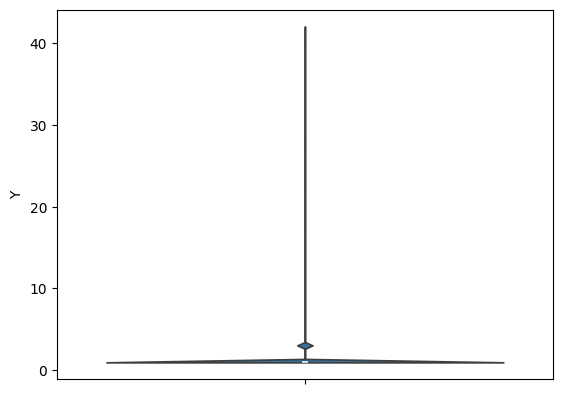

In [8]:
#plot the distribution of y_length
print(y_length.value_counts().sort_values(ascending=False))
sns.violinplot(y_length)

In [9]:
train_dataset["Y"] = train_dataset["Y"].apply(lambda x: np.mean(x))
valid_dataset["Y"] = valid_dataset["Y"].apply(lambda x: np.mean(x))
test_dataset["Y"] = test_dataset["Y"].apply(lambda x: np.mean(x))

In [10]:
#print the shape of the datasets
print("train_dataset shape : ", train_dataset.shape)
print("valid_dataset shape : ", valid_dataset.shape)
print("test_dataset shape : ", test_dataset.shape)

train_dataset shape :  (339855, 6)
valid_dataset shape :  (51080, 6)
test_dataset shape :  (100868, 6)


In [12]:
processed_dir = "processed_data"
os.makedirs(processed_dir, exist_ok=True)
train_dataset.to_csv(f"{processed_dir}/train.csv", index=False)
valid_dataset.to_csv(f"{processed_dir}/valid.csv", index=False)
test_dataset.to_csv(f"{processed_dir}/test.csv", index=False)
